# RKDE (Robust Kernel Density Estimation)

## Generating  the data set

In [85]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20,10)
def pdf(loc,variance,observation):
    '''Giving the Probability Density Function

    Parameters
    ----------
        loc (Int): Mean of the distribution ; where the peak of the bell exists
        variance(Int) : variance
        sample (Array) : the distribution

    Returns
    -------
        ndrray: Gaussian distribution
    '''
    # A normal continuous random variable.
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(observation - loc)/(2*variance)))
    return s1 * s2 

# Define the number of points
n_samples = 200

mu1, sigma1 = 0,1 # mean and variance
mu2, sigma2 = 15,1

x1 = np.random.normal(mu1,np.sqrt(sigma1),n_samples)
x2 = np.random.normal(mu2,np.sqrt(sigma2),n_samples)
# Adding outliers
outliers1 = np.random.uniform(5.5,6,10)
outliers2 = np.random.uniform(9,10,10)
X = np.array(list(x1) + list(x2))
outliers = np.append(outliers1, outliers2)
X = np.append(X, outliers)
#np.random.shuffle(X)
print("Dataset Shape: ", X.shape)
n_samples_final = X.shape[0]
# STANDARD DEVIATION
std = np.std(X)
# WINDOWS SIZE
#windows = (1/np.sqrt(n_samples_final)*20)
windows = 1.06 * n_samples_final**(-1/5) * std

Dataset Shape:  (420,)


## KDE functions

In [86]:
def kernel_function(obs,givenData,h,d=1):
    """ Kernel Function

    Parameters
    ----------
        obs (Int): Observation data
        h (Int): variance of the distribution
        d (Int, optional): dimension
        givenData (Int): Gaussian value
    
    Returns
    -------
        Int: kernel value   
    """
    result = (h**2 * 2*np.pi)**(-d/2) *np.exp((-1/2)* ((obs - givenData)/h)**2)
    return result

def kernel_density_function(obs_data,givenData,h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size
        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for g in givenData:
            k_result +=  (1/size) * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result

def kernel_density_function_for_rkde(obs_data,givenData,weights, h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size

        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    #weights = np.array(weights)
    #weights = np.array(weights)
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for index,g in enumerate(givenData):
            #print(index)
            k_result +=  weights[index] * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result 
# WINDOWS SIZE
windows = (1/np.sqrt(n_samples_final)*20)

In [87]:
from collections import Counter

def search_weight(X):
    count_weights = Counter(X)
    total = sum(count_weights.values())
    w_0 = [(count_weights[w] / total) for w in X]
    #print(count_weights)
    return w_0

def operand_2_func(index,weights,X,size_dist,windows):
    '''Generate operand 2

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size

    Returns
    -------
      int: operand 2
    '''
    #result = []
    result = 0
    for j in range(size_dist):
       #result.append(-2*weights[int(X[j])]*kernel_function(X[index],X[j],windows))
       result += weights[int(X[j])]*kernel_function(X[index],X[j],windows)
    result *= -2   
       #print(result)
    return result

def operand_3_func(weights,X, size_dist,windows):

  '''Generate operand 3

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size
    Returns
    ----------
      int: operand 3
    '''
  #final_result = []
  final_result = 0
  for i in range(size_dist):
    result = 0
    for j in range(size_dist):
      result += weights[int(X[i])]*weights[int(X[j])]*kernel_function(X[i],X[j],windows)
    #final_result.append(result)
    final_result += result
  return final_result

def huber_loss_func(value):
    alpha = 0.05
    #alpha = .0022
    #print(value)
    if value < -alpha:
        return -alpha
    elif -alpha <= value and value <= alpha:
        return value
    else:
        return alpha

def update_weights(value):
    #print("Huber loss")
    #print(huber_loss_func(value))
    return huber_loss_func(value) / value

#Step 4 : Normalize the updated weights
def normalize_weight(updated_weights,sum_weights):
    '''Normalize weight

    Parameters
    ----------
        updated_weights (int): the weights  
        sum_weights (array): summation of the initial weight

    Returns
    -------
      int:  normalized weight
    '''
    return updated_weights / sum_weights
    
#Step 5 : If the algorithm converges
def convergence(w_0,normalized_weights):
    """ powered_w_0 = [x**2 for x in w_0]
    powered_normalized_weights = [x**2 for x in normalized_weights]
    convergence = (np.dot(w_0,normalized_weights)) / (np.sqrt(sum(powered_w_0)) * np.sqrt(sum(powered_normalized_weights))) """
    power_difference = np.power(np.subtract(w_0,normalized_weights),2)
    convergence = np.sqrt(sum(power_difference))
    return convergence

In [88]:
w_0 = search_weight(X)
print("100 First weight of the distribution\n")
print(w_0[:10])
print("\nWeights of the outliers")
print(w_0[:10])
print(sum(w_0))

100 First weight of the distribution

[0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381]

Weights of the outliers
[0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381, 0.002380952380952381]
0.999999999999997


## Applying the process 

In [89]:

""" def process(X, outliers, w_0, size_sample, windows, k = 1,alpha=.6):
    ## STEP 1
    
    ## Step 2
    operand_1 = kernel_function(X[k-1],X[k-1],windows)
    operand_2 = operand_2_func(k-1,w_0,X,size_sample,windows)
    operand_3 = operand_3_func(w_0,X,size_sample,windows)
    step2_result = np.sqrt(operand_1 + operand_2 + operand_3)

    ## Step 3
    updated_weights = [update_weights(value) for value in step2_result]
    
    ## Step 4
    normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]
    #print(normalized_weights[-10:])
    ## Step 5
    #print(w_0[:100])
    #print("\n")
    #print(normalized_weights)
    convergence_val = convergence(w_0,normalized_weights)
    print("Convergence")
    print(convergence_val)
    #print(X.shape[0])
    #print(normalized_weights)

    if (np.round(convergence_val,3) > alpha):
        w_0 = normalized_weights
        print("\nNew weights outliers")
        print(w_0[-10:])

        k += 1
        print("iteration")
        print(k)
        process(X, outliers, w_0, size_sample, windows, k, alpha)
    else:
        print("else")
        new_X = np.random.choice(X,n_samples_final,p=normalized_weights)
        X_rkde = kernel_density_function_for_rkde(bins,new_X,normalized_weights,windows)
        ##### PLOTING ##########
        plt.xlabel("$x$")
        plt.ylabel("pdf")

        plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
        #plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

        plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
        #plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

        plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
        plt.plot(bins, X_rkde, color='red', label="RKDE", dashes=[6,5])
        plt.legend()
        plt.show() """

#process(X, outliers,w_0,n_samples_final,windows)      

' def process(X, outliers, w_0, size_sample, windows, k = 1,alpha=.6):\n    ## STEP 1\n    \n    ## Step 2\n    operand_1 = kernel_function(X[k-1],X[k-1],windows)\n    operand_2 = operand_2_func(k-1,w_0,X,size_sample,windows)\n    operand_3 = operand_3_func(w_0,X,size_sample,windows)\n    step2_result = np.sqrt(operand_1 + operand_2 + operand_3)\n\n    ## Step 3\n    updated_weights = [update_weights(value) for value in step2_result]\n    \n    ## Step 4\n    normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]\n    #print(normalized_weights[-10:])\n    ## Step 5\n    #print(w_0[:100])\n    #print("\n")\n    #print(normalized_weights)\n    convergence_val = convergence(w_0,normalized_weights)\n    print("Convergence")\n    print(convergence_val)\n    #print(X.shape[0])\n    #print(normalized_weights)\n\n    if (np.round(convergence_val,3) > alpha):\n        w_0 = normalized_weights\n        print("\nNew weights outliers")\n        print(w_0

In [90]:
def process(X, w_0, windows, k=1, alpha=.001,iterations={}):
    #new_weights = []
    updated_weights = []
    step2_result = []
    length = len(X)
    operand_3 = operand_3_func(w_0,X,length,windows)
    for index in range(length):
        ## Step 2
        operand_1 = kernel_function(X[index],X[index],windows)
        operand_2 = operand_2_func(index,w_0,X,length,windows)
        
        result = np.sqrt(operand_1 + operand_2 + operand_3)
        step2_result.append(result) 
        ## Step 3   
        updated_weights.append(update_weights(result))
    ## Step 3
    """ for value in step2_result:
        updated_weights.append(update_weights(value)) """
    
    print("Summation of weights after updating {}".format(sum(updated_weights)))
    print(updated_weights)
    ## Step 4
    normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]
    """ print(normalized_weights[:10])
    print(sum(normalized_weights)) """
    ## Step 5
    #print("\n")
    #print(normalized_weights[:100])
    convergence_val = convergence(w_0,normalized_weights)
    print("Convergence")
    print(convergence_val)
    #print(X.shape[0])
    #print(normalized_weights)
    iterations[k] = normalized_weights
    if(k<15):
    ##if (np.round(convergence_val,3) > alpha):
        print("iteration")
        
        """ print(k)
        print(w_0[10:-10]) """
        w_0 = normalized_weights
        #print("\nNew Weights Outliers")
        #print(w_0[:-50])
        k = k + 1
        print("New K")
        print(k)
        """ if k==101 :
            return """
        process(X, w_0, windows,k,iterations=iterations)
    else:
        print("INTERATIONS AND NORMALIZED WEIGHT")
        print(iterations)
        n_samples_final = X.shape[0]
        bins = np.linspace(np.min(X),np.max(X),n_samples_final)
        # Calculation of the KDE
        #X_kde = kernel_density_function(bins,X,windows)
        #new_X = np.random.choice(X,n_samples_final,p=normalized_weights)
        # Calculation of the RKDE with the new weights
        #X_rkde = kernel_density_function_for_rkde(bins,X,normalized_weights,windows)
        ##### PLOTING ##########
        #plt.xlabel("$x$")
        #plt.ylabel("pdf")

        #plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
        #plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

        #plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
        #plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

        #plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
        #plt.plot(bins, X_rkde, color='red', label="RKDE", dashes=[6,5])
        #plt.legend()
        #plt.show()
        
    return iterations    

""" for i in range(len(X)):
    new_weights.append(process(i,X,w_0,windows))"""


#print(sum(weights[-20:]))
#print("\n")
#print(sum(new_weights[-20:]))

' for i in range(len(X)):\n    new_weights.append(process(i,X,w_0,windows))'

In [91]:
record_weights = process(X, w_0, windows)

Summation of weights after updating 39.04940164792649
[0.10142296051396468, 0.0931564643043505, 0.0972659880766837, 0.10122456126392718, 0.07863216874765791, 0.09361343721408702, 0.09712295991384026, 0.09498964823545804, 0.08271807196315951, 0.087063443532757, 0.09365439509683499, 0.09119837452398384, 0.09181913144890856, 0.09867300449681991, 0.08456334233984815, 0.09685201187239777, 0.08615506606317246, 0.09891382953615224, 0.07159374746197197, 0.09876356902930795, 0.10052831822106359, 0.09131037875753202, 0.10116022939214822, 0.10059923260868917, 0.1005524588880245, 0.10071867658175869, 0.0940110149920914, 0.09304971503598629, 0.10047580769464018, 0.09049049929977539, 0.09840422502301066, 0.08193952248479257, 0.09153868951144986, 0.08789386401889186, 0.08119285798687946, 0.082681560535127, 0.09604210889807395, 0.09060150577238141, 0.10058517391423115, 0.09877818783304439, 0.10063988952508363, 0.10075060881048876, 0.10014014792184887, 0.1014211433981802, 0.07624198536566985, 0.1014152

In [92]:
for i in range(1,len(record_weights)+1):
    print(record_weights[i][-20:])
    print("\n")

[0.0018134456121850803, 0.0018135615643935746, 0.001813473237523583, 0.0018136328121930688, 0.001812215970308111, 0.001813825443049939, 0.0018137420261850315, 0.0018135406163177, 0.001813846125348773, 0.0018138033352339046, 0.0018105881450900811, 0.0018114952743070705, 0.001812708490771566, 0.0018118573911384643, 0.0018114110045317695, 0.0018112791061671318, 0.001809224885926498, 0.0018116443053076722, 0.0018104885048960675, 0.0018126999381917934]


[0.0018065166735309246, 0.0018066327730135267, 0.0018065443291190152, 0.001806707740404251, 0.001805298047411515, 0.0018068986779302622, 0.0018068136578504876, 0.0018066161328237757, 0.001806918658952487, 0.0018068752702534011, 0.0018014779012472581, 0.0018023149591520776, 0.0018034391990101636, 0.0018026637409568089, 0.0018022553915337549, 0.0018021347058956164, 0.0018002209794216843, 0.0018024525643876772, 0.0018014112624222588, 0.0018034304334684447]


[0.00179686985053119, 0.0017969852523409143, 0.0017968973387593049, 0.0017970606314338

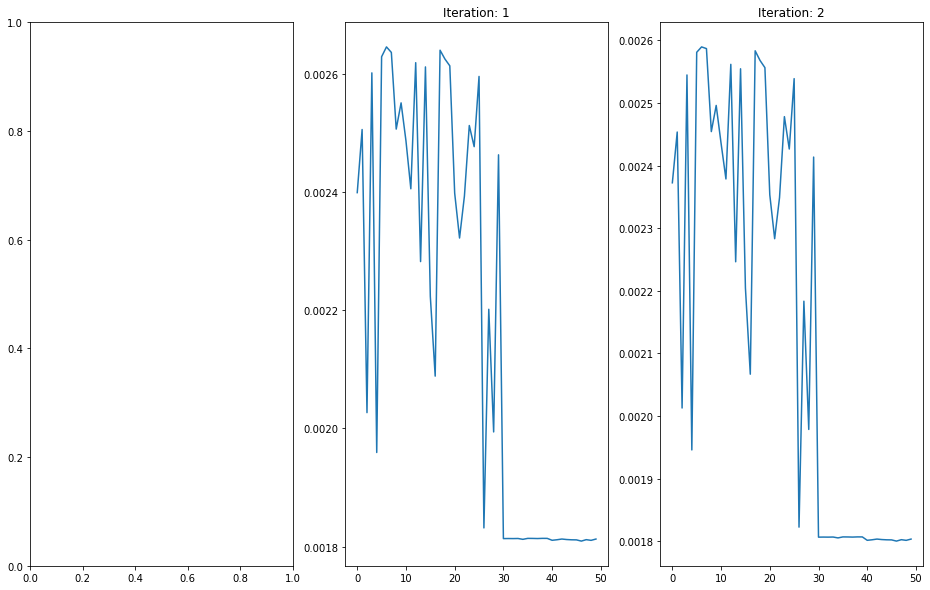

In [93]:
new_outliers = []

len(record_weights)
fig, ax  = plt.subplots(ncols=3,figsize=(16,10))
for i in range(1,3):
    x = range(50)
    y = record_weights[i][-50:]
    ax[i].set_title("Iteration: {}".format(i))
    ax[i].plot(x,y)

plt.show()

In [94]:
print(record_weights[2][-50:][0])

0.002372373903407701


In [95]:
print(record_weights[3][-50:])

[0.0023671041251970486, 0.0024483443103219833, 0.0020032178433107674, 0.002541195376156206, 0.0019366837625708615, 0.002578921621352274, 0.0025871739308508802, 0.0025848416260600424, 0.0024490446568553904, 0.0024915395567145743, 0.002430159719869453, 0.002373323136207463, 0.0025585567860974567, 0.0022386312045095196, 0.0025513076863433208, 0.002196810797462276, 0.002057998969581391, 0.0025807714325151786, 0.0025649096213847143, 0.002553146070042221, 0.00234678213400304, 0.0022758160601343267, 0.0023421666668318446, 0.0024745117202042426, 0.0024208200358544424, 0.0025352014385347757, 0.0018127362209169075, 0.002175363716954988, 0.0019694806684118263, 0.0024077640871535866, 0.00179686985053119, 0.0017969852523409143, 0.0017968973387593049, 0.0017970606314338608, 0.0017956615550171941, 0.0017972499618206764, 0.0017971650966779956, 0.0017969697419008277, 0.0017972696500918458, 0.0017972263926571976, 0.001791531543898364, 0.001792352994574368, 0.0017934584718671987, 0.001792702221511942, 0.